# CNN-LSTM


In [34]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import pytz
import numpy as np
import os
import sys
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import re
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset, TensorDataset


scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize_new_data

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_device(device)

cuda


In [36]:
# Define the directory and base filename pattern
file_pattern = "../data/final_data/cleaned_compiled_data_normalized_part*.csv"

# Use glob to get a sorted list of all matching CSV parts
csv_files = sorted(glob.glob(file_pattern))

# Load and concatenate all parts
data = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Done! Now `data` holds the full combined normalized DataFrame
print(f"Loaded {len(csv_files)} files. Final shape: {data.shape}")

Loaded 2 files. Final shape: (300282, 37)


In [37]:
chosen_stations = ['S104', 'S107', 'S109', 'S115', 'S116', 'S43', 'S50']
pixel_coords = [(4, 11, 'S109'),
 (2, 7, 'S50'),
 (1, 16, 'S107'),
 (2, 13, 'S43'),
 (0, 0, 'S115'),
 (0, 6, 'S116'),
 (8, 8, 'S104')]
def tabular_to_image(data: pd.DataFrame, pixel_coords, image_shape=(9, 18)):
    feature_types = ['rainfall', 'air_temperature', 'wind_speed', 'relative_humidity', 'wind_direction']
    H, W = image_shape
    T = data.shape[0]
    image = np.full((T, H, W, len(feature_types)), np.nan, dtype=np.float32)

    feature_to_channel = {feat: i for i, feat in enumerate(feature_types)}

    for y, x, station_id in pixel_coords:
        for feat in feature_types:
            col_name = f"{feat}_{station_id}"
            if col_name in data.columns:
                channel = feature_to_channel[feat]
                image[:, y, x, channel] = data[col_name].values

    return image if T > 1 else image[0]


In [38]:
class LightningDataset_Modified(Dataset):
    def __init__(self, compiled_df, pixel_coords, image_shape=(9, 18), timezone_str="Asia/Singapore", reject_zeros=True, interpolate=True):
        self.compiled_df = compiled_df.copy()
        self.pixel_coords = pixel_coords
        self.image_shape = image_shape
        self.timezone = pytz.timezone(timezone_str)
        self.samples = []
        self.reject_zeros = reject_zeros
        self.rejected_samples = []
        self.interpolate = interpolate

        self._prepare_dataset()

    def _prepare_dataset(self):
        # Ensure datetime index
        self.compiled_df["Timestamp"] = pd.to_datetime(self.compiled_df["Timestamp"])
        if not isinstance(self.compiled_df.index, pd.DatetimeIndex):
            self.compiled_df.set_index("Timestamp", inplace=True)
        self.compiled_df.index = self.compiled_df.index.tz_localize(None)

        # Drop target for input features
        input_df = self.compiled_df.drop(columns=["Lightning_Risk"])

        # Valid 2-hour timestamps
        min_ts = self.compiled_df.index.min().ceil("2h") + pd.Timedelta(hours=2)
        max_ts = self.compiled_df.index.max().floor("2h")
        valid_ts = self.compiled_df.loc[
            (self.compiled_df.index >= min_ts) &
            (self.compiled_df.index <= max_ts) &
            (self.compiled_df.index.hour % 2 == 0) &
            (self.compiled_df.index.minute == 0)
        ].index

        for timestamp in valid_ts:
            try:
                # Input time windows (past 5)
                input_times = [timestamp - pd.Timedelta(minutes=delta) for delta in [120, 90, 60, 30, 0]]
                input_slices = self.compiled_df.loc[input_times]
                input_images = tabular_to_image(input_slices, self.pixel_coords, self.image_shape)  # (5, H, W, C)

                # Rearrange to (C, T, H, W) if needed
                input_tensor = np.transpose(input_images, (3, 0, 1, 2))  # (C, T, H, W)

                if self.interpolate:
                    input_tensor = self.interpolate_nan(input_tensor)

                # Output time windows (future 5)
                output_times = [timestamp + pd.Timedelta(minutes=delta) for delta in [0, 30, 60, 90, 120]]
                output_data = self.compiled_df.loc[output_times, "Lightning_Risk"].astype(int).values.flatten()

                if self.reject_zeros and not (output_data == 1).any():
                    input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
                    output_data = torch.tensor(output_data, dtype=torch.float32)
                    self.rejected_samples.append((input_tensor, output_data))
                    continue

                self.samples.append((torch.tensor(input_tensor, dtype=torch.float32), torch.tensor(output_data, dtype=torch.float32)))

            except KeyError:
                continue  # Skip if any timestamps are missing

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        x = x.permute(1, 0, 2, 3)  # (C, T, H, W) → (T, C, H, W)
        return x, y

    def get_positive_ratio(self):
        all_labels = np.array([sample[1] for sample in self.samples])  # shape (N, 5)
        total = all_labels.size
        positives = (all_labels == 1).sum()
        return positives / total

    def get_rejected_samples(self):
        inputs, outputs = zip(*self.rejected_samples)
        input_tensor = torch.stack(inputs)  # Could be (N, C, T, H, W)
        output_tensor = torch.stack(outputs)

        input_tensor = input_tensor.permute(0, 2, 1, 3, 4)

        return torch.utils.data.TensorDataset(input_tensor, output_tensor)

    def interpolate_nan(self, x):
        # x: (C, T, H, W)
        C, T, H, W = x.shape
        for t in range(T):
            for c in range(C):
                frame = x[c, t]
                nan_mask = ~np.isnan(frame)
                frame = np.nan_to_num(frame, nan=0.0)

                frame_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                mask_tensor = torch.tensor(nan_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

                kernel = torch.ones(1, 1, 5, 5) / 25.0
                blurred = F.conv2d(frame_tensor, kernel, padding=2)
                weight = F.conv2d(mask_tensor, kernel, padding=2)

                interpolated = blurred / (weight + 1e-6)
                x[c, t] = interpolated.squeeze().cpu().numpy()

        return x

    @classmethod
    def from_saved(cls, saved_path, compiled_df, pixel_coords, image_shape=(9, 18), timezone_str="Asia/Singapore"):
        # Create empty instance without triggering __init__
        self = cls.__new__(cls)

        # Manually set attributes
        self.compiled_df = compiled_df
        self.pixel_coords = pixel_coords
        self.image_shape = image_shape
        self.timezone = pytz.timezone(timezone_str)
        self.reject_zeros = True  # or False, based on what was used when saving
        self.interpolate = True   # same here

        # Load samples
        saved = torch.load(saved_path)
        self.samples = saved["samples"]
        self.rejected_samples = saved["rejected_samples"]

        return self

In [40]:
# Path to the saved dataset
saved_path = "../data/CNN_dataset/lightning_dataset_processed_interpolated.pt"

if os.path.exists(saved_path):
    # Load directly from saved file
    dataset = LightningDataset_Modified.from_saved(saved_path, data, pixel_coords)
else:
    # Create from scratch
    dataset = LightningDataset_Modified(data, pixel_coords, reject_zeros=True)

In [41]:
dataset[0]

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.6852, 0.6852, 0.6852,  ..., 0.7294, 0.6115, 0.6115],
           [0.6852, 0.6852, 0.6852,  ..., 0.7294, 0.6115, 0.6115],
           [0.6852, 0.6852, 0.6852,  ..., 0.7294, 0.6115, 0.6115],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.4987, 0.4987, 0.4987,  ..., 0.5585, 0.5893, 0.5893],
           [0.4987, 0.4987, 0.4987,  ..., 0.5585, 0.5893, 0.5893],
           [0.4987, 0.49

In [42]:
len(dataset)

1528

In [43]:
def get_positive_ratio(samples):
    # Move the labels to CPU if they are on a GPU
    all_labels = np.array([sample[1].cpu().numpy() for sample in samples])  # shape (N, 5)
    
    total = all_labels.size
    positives = (all_labels == 1).sum()

    positive_ratio = positives / total
    return positive_ratio


In [44]:
len(dataset)

1528

In [45]:
# Set seed for reproducibility
g = torch.Generator(device).manual_seed(42)
train_ratio = 0.8
# Calculate split sizes
train_size = int(train_ratio* len(dataset))
val_size = len(dataset) - train_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=g)

rejected_dataset = dataset.get_rejected_samples()
rejected_num = len(rejected_dataset)
print("Rejected samples:", rejected_num)

# Generate a shuffled list of indices (optional but recommended for randomness)
rejected_indices = torch.randperm(rejected_num, generator=g)

# Split indices based on ratio
train_split_idx = int(train_ratio*0.6 * rejected_num)
train_indices = rejected_indices[:train_split_idx]
val_indices = rejected_indices[train_split_idx:]

# Create Subsets
rejected_train = torch.utils.data.Subset(rejected_dataset, train_indices)
rejected_val = torch.utils.data.Subset(rejected_dataset, val_indices)

# Concatenate with original datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset, rejected_train])
val_dataset = torch.utils.data.ConcatDataset([val_dataset, rejected_val])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Rejected samples: 10343


In [46]:
train_p_r = get_positive_ratio(train_dataset)
print(train_p_r)

0.0930164888457808


In [47]:
class LightningRiskCNNLSTM(nn.Module):
    def __init__(self, num_channels=5, num_future_steps=5, hidden_size=256):
        super(LightningRiskCNNLSTM, self).__init__()

        # --- CNN Feature Extractor ---
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

        # Dynamically determine CNN output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, 9, 18)
            x = F.relu(self.conv1(dummy_input))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            self.feature_size = self.flatten(x).shape[1]

        # --- LSTM ---
        self.lstm = nn.LSTM(input_size=self.feature_size, hidden_size=hidden_size, batch_first=True)

        # --- Output Layer ---
        self.fc = nn.Linear(hidden_size, num_future_steps)

        # --- Learnable initial hidden state ---
        self.initial_hidden_state = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.initial_cell_state = nn.Parameter(torch.randn(1, 1, hidden_size))  # LSTM also has a cell state

    def forward(self, x):
        # x: (batch_size, seq_len=5, channels=5, height, width)
        batch_size, seq_len, c, h, w = x.shape

        cnn_features = []
        for t in range(seq_len):
            x_t = x[:, t]  # (batch, channels, height, width)
            x_t = torch.nan_to_num(x_t, nan=0.0)

            out = F.relu(self.conv1(x_t))
            out = F.relu(self.conv2(out))
            out = F.relu(self.conv3(out))
            out = self.flatten(out)

            cnn_features.append(out)

        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, seq_len, feature_size)

        # Expand learnable hidden state and cell state for batch
        h0 = self.initial_hidden_state.expand(1, batch_size, -1).contiguous()
        c0 = self.initial_cell_state.expand(1, batch_size, -1).contiguous()

        # LSTM
        lstm_out, _ = self.lstm(cnn_features, (h0, c0))

        # Final hidden state (from the last time step)
        final_hidden = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Risk prediction without sigmoid (for BCEWithLogitsLoss)
        predictions = self.fc(final_hidden)  # (batch_size, num_future_steps)

        return predictions

In [48]:
for i in range(len(train_dataset)):
    x, y = train_dataset[i]
    if x.shape != (5, x.shape[1], x.shape[2], x.shape[3]):  # Assuming T=5 fixed
        print(f"Sample {i} has unexpected x shape: {x.shape}")
    if y.shape != torch.Size([5]):
        print(f"Sample {i} has unexpected y shape: {y.shape}")

In [49]:
model = LightningRiskCNNLSTM().to(device)
# Get one batch
for batch_x, batch_y in train_dataloader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)


In [50]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # no sigmoid in model

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


In [51]:
def train(dataloader, model, num_epochs, learning_rate, device=device, train_p_r=train_p_r):
    model.train()
    model.to(device)  # Ensure model is on GPU/CPU

    # Binary Cross Entropy Loss for multi-label binary outputs
    
    #criterion = nn.BCELoss()
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_p_r]).to(device)) #make sure no sigmoid on the other side
    criterion = FocalLoss(alpha= 0.9, gamma=2).to(device) 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # List to track the average loss for every epoch (including epoch 0)
    avg_loss_history = []

    os.makedirs("models", exist_ok=True)  # Ensure the directory exists
    timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)   # (B, T, C, H, W)
            targets = targets.to(device)  # (B, 5) — each value ∈ [0, 1]

            optimizer.zero_grad()

            predictions = model(inputs)  # Output shape: (B, 5)

            loss = criterion(predictions, targets)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataloader)

        # Save the average loss every 5 epochs for monitoring
        if (epoch) % 5 == 0:
            avg_loss_history.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

        if (epoch) % 20 == 0:
            filename = f'model_{timestamp}_{avg_loss:0.6f}_{epoch}.pth'
            torch.save(model.state_dict(), os.path.join("models", filename))
            print(f"Model saved as {filename}")
    final_filename = f'model_{timestamp}_{avg_loss:0.6f}_{num_epochs-1}.pth'
    torch.save(model.state_dict(), os.path.join("models", final_filename))
    print(f"Final model saved as {final_filename}")

    # Save the model with timestamp and final loss at the end of training
    final_loss = avg_loss_history[-1] if avg_loss_history else 0
    
    filename = f'model_{timestamp}_{final_loss:0.6f}.pth'

    # Save model state
    
    torch.save(model.state_dict(), os.path.join("models", filename))
    print(f"Model saved as {filename}")

    # Plotting the average loss every epoch (including epoch 0) in two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot with standard y-axis
    axs[0].plot(range(0,num_epochs,5), avg_loss_history, label='Average Loss (every epoch)', color='blue')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Average Training Loss Over Time (Standard Y-Axis)')
    axs[0].grid(True)
    axs[0].legend()

    # Plot with logarithmic y-axis
    axs[1].plot(range(0,num_epochs,5), avg_loss_history, label='Average Loss (every epoch)', color='blue')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Average Training Loss Over Time (Logarithmic Y-Axis)')
    axs[1].set_yscale('log')  # Set the y-axis to logarithmic scale
    axs[1].grid(True)
    axs[1].legend()

    # Save the plot as an image
    os.makedirs("plots", exist_ok=True)  # Ensure the directory exists
    plot_filename = f'loss_plot_{timestamp}.png'
    plt.savefig(os.path.join("plots", plot_filename))
    print(f"Plot saved as {plot_filename}")

    # Show the plot
    plt.show()

    return avg_loss_history  # Return the loss history


In [52]:
model = LightningRiskCNNLSTM().to(device)
%timeit -r 1 -n 1 train(dataloader = train_dataloader, model = model, num_epochs = 300, learning_rate = 1e-4)

Epoch 1/300 - Avg Loss: 0.0778
Model saved as model_2025_04_19_21_57_0.077844_0.pth
Epoch 6/300 - Avg Loss: 0.0561
Epoch 11/300 - Avg Loss: 0.0519
Epoch 16/300 - Avg Loss: 0.0499
Epoch 21/300 - Avg Loss: 0.0479
Model saved as model_2025_04_19_21_57_0.047857_20.pth
Epoch 26/300 - Avg Loss: 0.0449
Epoch 31/300 - Avg Loss: 0.0422
Epoch 36/300 - Avg Loss: 0.0387
Epoch 41/300 - Avg Loss: 0.0346
Model saved as model_2025_04_19_21_57_0.034642_40.pth
Epoch 46/300 - Avg Loss: 0.0296
Epoch 51/300 - Avg Loss: 0.0245
Epoch 56/300 - Avg Loss: 0.0194
Epoch 61/300 - Avg Loss: 0.0147
Model saved as model_2025_04_19_21_57_0.014723_60.pth
Epoch 66/300 - Avg Loss: 0.0118
Epoch 71/300 - Avg Loss: 0.0079
Epoch 76/300 - Avg Loss: 0.0054
Epoch 81/300 - Avg Loss: 0.0042
Model saved as model_2025_04_19_21_57_0.004250_80.pth
Epoch 86/300 - Avg Loss: 0.0032
Epoch 91/300 - Avg Loss: 0.0023
Epoch 96/300 - Avg Loss: 0.0031
Epoch 101/300 - Avg Loss: 0.0013
Model saved as model_2025_04_19_21_57_0.001318_100.pth
Epoch

KeyboardInterrupt: 

In [26]:
def extract_epoch(filename):
    match = re.search(r"_(\d+)\.pth$", filename)
    return int(match.group(1)) if match else -1



In [27]:
# Define the directory and base filename pattern
file_path_test = "../data/test_data/cleaned_compiled_data_normalized.csv"

# Load and concatenate all parts
test_data = pd.read_csv(file_path_test)

In [28]:
test_dataset = LightningDataset_Modified(test_data,pixel_coords,reject_zeros=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, generator=g)

In [29]:
def safe_sigmoid(x):
    # If all outputs are already in [0, 1], assume sigmoid already applied
    if x.min() >= 0 and x.max() <= 1:
        return x  # Already probabilities
    return torch.sigmoid(x)  # Assume logits

def evaluate_metrics(dataloader, model, device="cuda"):
    model.eval()
    model.to(device)
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            # Convert from NumPy if needed
            if isinstance(inputs, np.ndarray):
                inputs = torch.tensor(inputs)
            if isinstance(targets, np.ndarray):
                targets = torch.tensor(targets)

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            
            probs = safe_sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    accuracy = (all_preds == all_targets).mean() * 100
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1


In [32]:
def evaluate_all_checkpoints(model_class, checkpoint_dir, train_loader, val_loader, test_loader, device="cuda"):
    import os, glob
    import matplotlib.pyplot as plt
    import torch

    model_paths = sorted(glob.glob(f"./models/{checkpoint_dir}_*.pth"), key=extract_epoch)
    results = []

    best_val_f1 = -1
    best_model_state = None

    for path in model_paths:
        epoch = extract_epoch(path)
        if epoch == -1:
            continue
        print(f"\nEvaluating model at epoch {epoch}...")

        model = model_class()
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        model.eval()

        train_metrics = evaluate_metrics(train_loader, model, device)
        val_metrics = evaluate_metrics(val_loader, model, device)
        test_metrics = evaluate_metrics(test_loader, model, device)

        print(f"Epoch {epoch}:")
        print(f"  Train Acc: {train_metrics[0]:.2f}% | F1: {train_metrics[3]:.4f}")
        print(f"  Val Acc  : {val_metrics[0]:.2f}% | F1: {val_metrics[3]:.4f}")
        print(f"  Test Acc : {test_metrics[0]:.2f}% | F1: {test_metrics[3]:.4f}")

        results.append((epoch, *train_metrics, *val_metrics, *test_metrics))

        if val_metrics[3] > best_val_f1:
            best_val_f1 = val_metrics[3]
            best_model_state = model.state_dict()

    # Save best model
    if best_model_state:
        best_path = f"./models/{checkpoint_dir}_best_{val_metrics[3]}.pth"
        torch.save(best_model_state, best_path)
        print(f"\n✅ Best model saved to {best_path} with Val F1 = {best_val_f1:.4f}")

    # Extract metrics
    epochs = [r[0] for r in results]
    train_accs = [r[1] for r in results]
    train_f1s = [r[4] for r in results]
    val_accs = [r[5] for r in results]
    val_f1s = [r[8] for r in results]
    test_accs = [r[9] for r in results]
    test_f1s = [r[12] for r in results]

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy Plot
    axs[0].plot(epochs, train_accs, label="Train Accuracy", color="blue", marker="o")
    axs[0].plot(epochs, val_accs, label="Val Accuracy", color="green", marker="s")
    axs[0].plot(epochs, test_accs, label="Test Accuracy", color="teal", marker="^")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy (%)")
    axs[0].legend()
    axs[0].set_ylim(0, 100)
    axs[0].grid(True)

    # F1 Score Plot
    axs[1].plot(epochs, train_f1s, label="Train F1", color="purple", marker="o")
    axs[1].plot(epochs, val_f1s, label="Val F1", color="orange", marker="s")
    axs[1].plot(epochs, test_f1s, label="Test F1", color="red", marker="^")
    axs[1].set_title("F1 Score over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("F1 Score")
    axs[1].legend()
    axs[1].set_ylim(0, 1)
    axs[1].grid(True)

    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plot_filename = f"./plots/metrics_{checkpoint_dir}.png"
    plt.savefig(plot_filename)
    print(f"\n📈 Metrics plot saved to {plot_filename}")
    plt.show()

    return results



Evaluating model at epoch 0...
Epoch 0:
  Train Acc: 91.21% | F1: 0.1580
  Val Acc  : 97.28% | F1: 0.1506
  Test Acc : 93.22% | F1: 0.1352

Evaluating model at epoch 20...
Epoch 20:
  Train Acc: 92.74% | F1: 0.4500
  Val Acc  : 97.01% | F1: 0.3063
  Test Acc : 93.22% | F1: 0.3143

Evaluating model at epoch 40...
Epoch 40:
  Train Acc: 94.89% | F1: 0.6349
  Val Acc  : 96.99% | F1: 0.3188
  Test Acc : 93.56% | F1: 0.3487

Evaluating model at epoch 60...
Epoch 60:
  Train Acc: 98.11% | F1: 0.8900
  Val Acc  : 96.62% | F1: 0.3201
  Test Acc : 93.65% | F1: 0.4389

Evaluating model at epoch 80...
Epoch 80:
  Train Acc: 99.86% | F1: 0.9926
  Val Acc  : 96.02% | F1: 0.3109
  Test Acc : 92.96% | F1: 0.4605

Evaluating model at epoch 100...
Epoch 100:
  Train Acc: 99.99% | F1: 0.9996
  Val Acc  : 96.45% | F1: 0.3051
  Test Acc : 93.39% | F1: 0.4441

Evaluating model at epoch 120...
Epoch 120:
  Train Acc: 100.00% | F1: 0.9998
  Val Acc  : 96.33% | F1: 0.3061
  Test Acc : 92.62% | F1: 0.4281

Ev

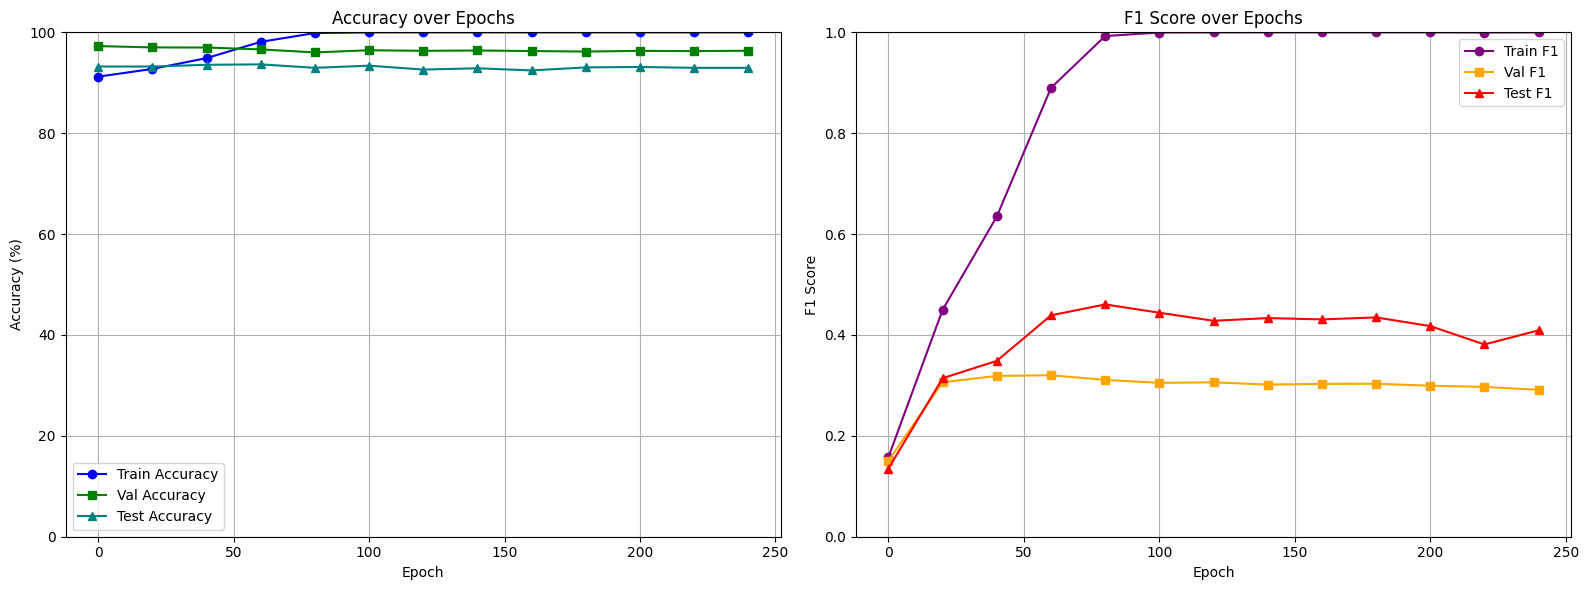

In [53]:
model_timestamp = "model_2025_04_19_21_57"

results = evaluate_all_checkpoints(
    model_class=LightningRiskCNNLSTM,
    checkpoint_dir=model_timestamp,  # Folder with .pth files
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    test_loader = test_dataloader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)